In [2]:
from random import random, seed, randrange
from math import floor, pi
import matplotlib.pyplot as plt
import numpy as np
import os
from time import time
import pandas as pd
from scipy.integrate import simps, trapz, cumtrapz

In [3]:
Tc_co = 304.2 #K
Tc_me = 190.6 #K
Pc_co = 73.76 #bar
Pc_me = 46 #bar
ohm_co = 0.225
ohm_me = 0.008
Tb_co = 194.7 #K
Tb_me = 111.7 #K

R = .08314 #L*bar/mol/K

In [4]:
P_res = 100 #bar
T = 318.15 #K
yco = 0.5

In [5]:
def kappa(ohm):
    return 0.37464 + 1.5422*ohm - 0.26992*ohm**2

def alpha(kappa, Tc, T):
    return ( 1 + kappa*(1 - np.sqrt(T/Tc) ) )**2

def a( Tc, Pc, alpha, P_res, T ):
    R = .08314 #L*bar/mol/K
    return 0.45724*R**2*Tc**2*alpha/Pc

def A( a, P_res, T ):
    R = .08314 #L*bar/mol/K
    return a*P_res/R**2/T**2

def b( Tc, Pc ):
    R = .08314 #L*bar/mol/K
    return 0.07780*R*Tc/Pc

def B( b, P_res, T):
    R = .08314 #L*bar/mol/K
    return b*P_res/R/T

def solveZ( A, B ):
    c1 = B-1
    c2 = A - 3*B**2 - 2*B
    c3 = B**3 + B**2 - A*B
    roots = np.roots( [1, c1, c2, c3] )
    for r in roots:
        if( r.imag == 0):
            return( r.real )
    else:
        stop()


In [6]:
kappa_me = kappa( ohm_me )
alpha_me = alpha( kappa_me, Tc_me, T)
a_me = a( Tc_me, Pc_me, alpha_me, P_res, T )
A_me = A( a_me, P_res, T )
b_me = b( Tc_me, Pc_me )
B_me = B( b_me, P_res, T)
Z_me = solveZ( A_me, B_me)
print( Z_me )

kappa_co = kappa( ohm_co )
alpha_co = alpha( kappa_co, Tc_co, T)
a_co = a( Tc_co, Pc_co, alpha_co, P_res, T )
A_co = A( a_co, P_res, T )
b_co = b( Tc_co, Pc_co )
B_co = B( b_co, P_res, T)
Z_co = solveZ( A_co, B_co)
print( Z_co )

0.8669769685040651
0.36145721772975103


In [7]:
a_cm = np.sqrt(a_me*a_co )
A_cm = A( a_cm, P_res, T)

a_mix = yco*yco*a_co + 2*yco*(1-yco)*a_cm + (1-yco)*a_me
b_mix = yco*b_co + (1-yco)*b_me

A_mix = A( a_mix, P_res, T )
B_mix = B( b_mix, P_res, T )
Z_mix = solveZ( A_mix, B_mix )
Z_mix

0.598763228271006

In [8]:
def Fi( Aii, Ajj, Aij, A_mix, Bi, B_mix, Z_mix, yi, P_res ):
    term1 = Bi*(Z_mix - 1)/B_mix
    term2 = np.log( Z_mix - B_mix )
    term3 = A_mix/( 2*np.sqrt(2)*B_mix )
    term4 = 2*( yi*Aii + (1-yi)*Aij )/A_mix - Bi/B_mix
    term5 = (Z_mix + (1 + np.sqrt(2))*B_mix )/(Z_mix + (1 - np.sqrt(2))*B_mix )
    term6 = term1 - term2 - term3*term4*np.log( term5 )
    return yi*P_res*np.exp( term6 )

F_me = Fi( A_me, A_co, A_cm, A_mix, B_me, B_mix, Z_mix, 1-yco, P_res)
F_co = Fi( A_co, A_me, A_cm, A_mix, B_co, B_mix, Z_mix, yco, P_res)
print( F_me )
print( F_co )
    

50.41461354022311
34.1430653822625


In [9]:
def fugacity( P, yco, co2_data, me_data, species):
    if( species == "co2"):
        return np.interp( P, co2_data.P, co2_data.F)*yco
    if( species == "me"):
        return np.interp( P, me_data.P, me_data.F)*(1-yco)

    
    
co2_data = pd.read_csv('c02.txt', sep = '\t')
co2_data['P'] = co2_data['Pressure (bar)']
co2_data['T'] = co2_data['Temperature (K)']
co2_data['V'] = co2_data['Volume (l/mol)']
co2_data['Z'] = co2_data.V * co2_data.P/(.08314)/(318.15)
exp = ( co2_data.Z - 1 )/co2_data.P
integral = cumtrapz( exp, co2_data.P)
thiele = np.exp( integral )
thiele = np.insert(thiele, 0,1)
co2_data['F'] = thiele*co2_data.P

me_data = pd.read_csv('ch4.txt', sep = '\t')
me_data['P'] = me_data['Pressure (bar)']
me_data['T'] = me_data['Temperature (K)']
me_data['V'] = me_data['Volume (l/mol)']
me_data['Z'] = me_data.V * me_data.P/(.08314)/(318.15)
exp = ( me_data.Z - 1 )/me_data.P
integral = cumtrapz( exp, me_data.P)
thiele = np.exp( integral )
thiele = np.insert(thiele, 0,1)
me_data['F'] = thiele*me_data.P

fco = fugacity( P_res, yco, co2_data, me_data, "co2")
fme = fugacity( P_res, yco, co2_data, me_data, "me")

print( fme )
print( fco )

44.42385599273277
31.220446035265052


In [10]:
print( np.interp( P_res, me_data.P, me_data.Z) )
print( np.interp( P_res, co2_data.P, co2_data.Z) )

0.8889269971019235
0.3339307778676421


In [11]:
def Fone( Z, A, B, P_res):
    term1 = Z - 1 - np.log( Z - B)
    term2 = A/( 2*np.sqrt(2)*B )
    term3 = (Z + (1 + np.sqrt(2))*B )/(Z + (1 - np.sqrt(2))*B )
    term4 = term1 - term2*np.log( term3 )
    return np.exp( term4 )*P_res

print( Fone( Z_me, A_me, B_me, P_res ) )
print( Fone( Z_co, A_co, B_co, P_res ) )

85.38299517284635
59.417054924397775


In [12]:
print( A_co )
print( A_me )
print( A_cm)
print( A_mix )

0.548684849787577
0.2806932732513361
0.392443813137999
0.4737397556415618


In [13]:
print( B_co )
print( B_me )
print( B_mix )

0.10085233810024943
0.10132409514243347
0.10108821662134145


In [14]:
print( Z_me )
print( np.interp( P_res, me_data.P, me_data.Z) )

0.8669769685040651
0.8889269971019235


In [15]:
print( Z_co )
print( np.interp( P_res, co2_data.P, co2_data.Z) )

0.36145721772975103
0.3339307778676421


In [16]:
print( F_me )
print( Fone( Z_me, A_me, B_me, P_res )*(1-yco) )
print( fme )

50.41461354022311
42.691497586423175
44.42385599273277


In [17]:
print( F_co )
print( Fone( Z_co, A_co, B_co, P_res )*yco )
print( fco )

34.1430653822625
29.708527462198887
31.220446035265052


In [18]:
Pv = np.linspace( 5, 200, 40 )

In [36]:
def PR_Fugacity( P_res, T, yco):
    Tc_co = 304.2 #K
    Tc_me = 190.6 #K
    Pc_co = 73.76 #bar
    Pc_me = 46 #bar
    ohm_co = 0.225
    ohm_me = 0.008
    
    kappa_me = kappa( ohm_me )
    alpha_me = alpha( kappa_me, Tc_me, T)
    a_me = a( Tc_me, Pc_me, alpha_me, P_res, T )
    A_me = A( a_me, P_res, T )
    b_me = b( Tc_me, Pc_me )
    B_me = B( b_me, P_res, T)

    kappa_co = kappa( ohm_co )
    alpha_co = alpha( kappa_co, Tc_co, T)
    a_co = a( Tc_co, Pc_co, alpha_co, P_res, T )
    A_co = A( a_co, P_res, T )
    b_co = b( Tc_co, Pc_co )
    B_co = B( b_co, P_res, T)
    
    a_cm = np.sqrt(a_me*a_co )#*(1-0.0919)
    A_cm = A( a_cm, P_res, T)

    a_mix = yco*yco*a_co + 2*yco*(1-yco)*a_cm + (1-yco)*a_me
    b_mix = yco*b_co + (1-yco)*b_me

    A_mix = A( a_mix, P_res, T )
    B_mix = B( b_mix, P_res, T )
    Z_mix = solveZ( A_mix, B_mix )
    
    F_me = Fi( A_me, A_co, A_cm, A_mix, B_me, B_mix, Z_mix, 1-yco, P_res)
    F_co = Fi( A_co, A_me, A_cm, A_mix, B_co, B_mix, Z_mix, yco, P_res)
    
    return F_co, F_me

In [37]:
F_cov = np.zeros( 40 )
F_mev = np.zeros( 40 )
f_cov = np.zeros( 40 )
f_mev = np.zeros( 40 )
Pv = np.linspace( 5, 200, 40 )

yco = 0.5

for i in np.arange(40):
    F_cov[i], F_mev[i] = PR_Fugacity( Pv[i], T, yco)
    f_cov[i] = fugacity( Pv[i], yco, co2_data, me_data, "co2")
    f_mev[i] = fugacity( Pv[i], yco, co2_data, me_data, "me")


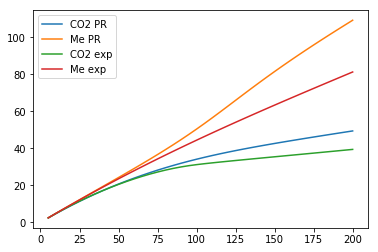

In [38]:
plt.plot( Pv, F_cov, label = "CO2 PR")
plt.plot( Pv, F_mev, label = "Me PR")
plt.plot( Pv, f_cov, label = "CO2 exp")
plt.plot( Pv, f_mev, label = "Me exp")
plt.legend()

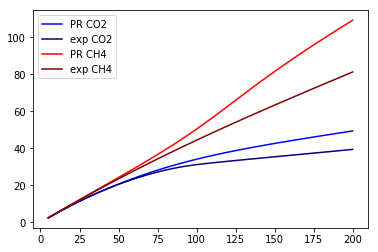

In [49]:
Pv = np.linspace( 5, 200, 40 )

for yi in [0.5]:
    F_PR_cov = np.zeros( 40 )
    F_exp_cov = np.zeros( 40 )
    F_PR_mev = np.zeros( 40 )
    F_exp_mev = np.zeros( 40 )
    for i in np.arange(40):
        F_PR_cov[i], F_PR_mev[i] = PR_Fugacity( Pv[i], T, yi)
        F_exp_cov[i] = fugacity( Pv[i], yi, co2_data, me_data, "co2")
        F_exp_mev[i] = fugacity( Pv[i], yi, co2_data, me_data, "me")
    plt.plot( Pv, F_PR_cov, color = (0,0,1), label = "PR CO2")
    plt.plot( Pv, F_exp_cov, color = (0,0,0.5), label = "exp CO2")
    plt.plot( Pv, F_PR_mev, color = (1,0,0), label = "PR CH4")
    plt.plot( Pv, F_exp_mev, color = (0.5,0,0), label = "exp CH4")    
    
plt.legend()
    